In [1]:
from helpers.notebook_dict import set_is_in_notebook

set_is_in_notebook(True)

import os
os.environ['FORCE_AGG'] = '1'
import numpy as np 
import IPython
import torch
from PIL import Image
import torch.nn.functional as F


from run_test import get_tester_and_dataset

T_Q10 = os.environ['T_OI_Q10']
T_Q15 = os.environ['T_OI_Q15']

os.environ['T_DIV_CROP_Q12'] = '/scratch_net/fryr/mentzerf/datasets/DIV2K_new/DIV2K_valid_HR_crop4;/scratch_net/fryr/mentzerf/datasets/DIV2K_new/DIV2K_valid_HR_crop4_bpg_q12'

L_Q10 = '1002_1751'
L_Q15 = '0930_1004'

DS_OI = '/srv/beegfs02/scratch/cnncompression/data/datasets/openimages/test_768_clean_m500'
DS_CB = 'checkerboard'
args = [
    os.environ['LOGS_THIRD'],# + '/AWS/',
    '1108_2150',
    os.environ['T_DIV_CROP_Q13'],
#     '/scratch_net/fryr/mentzerf/datasets/DIV2K_new/DIV2K_valid_HR_crop4_multi_q8_9_10_11_12_13_14_15',
#     '/scratch_net/fryr_second/mentzerf/datasets/RAISE_1k/RAISE_1k_raw_r100_crop16;/scratch_net/fryr_second/mentzerf/datasets/RAISE_1k/RAISE_1k_raw_r100_crop16_bpg_q12',
#     '/home/mentzerf/net_scratch/datasets/openimages_rand/val_oi_500_r_multi_q9_10_11_12_13_14_15',
  '--crop', '52'
]
t, ds = get_tester_and_dataset(args)

from modules import conditional_instance_norm

print(t.blueprint.net)

all_vars = conditional_instance_norm._all_vars
print([len(v) for v in all_vars.values()])

WRAN: using Agg backend linux
***No CUDA syncs for timings
Getting lock for /scratch_net/fryr/mentzerf/datasets/DIV2K_new/DIV2K_valid_HR_crop4/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=52; discard_s=False]: 0.00094
Getting lock for /scratch_net/fryr/mentzerf/datasets/DIV2K_new/DIV2K_valid_HR_crop4_bpg_q13/cached_glob.pkl: .cached_glob.lock [reset: False]...
>>> filter [min_size=52; discard_s=False]: 0.00068
Sorting...
Got 1 datasets.
Testing 1108_2150 at -1 ---
*** global_config fw_s=3
*** global_config long_means
*** global_config long_pis
*** global_config long_sigma
*** global_config gdn
*** global_config no_norm_final
*** global_config down_up=deconv
Updating config.lr.initial = 1e-05
Using global_config: GlobalConfig(
	down_up=deconv
	fw_s=3
	gdn
	long_means
	long_pis
	long_sigma
	lr.initial=1e-05
	no_norm_final
	unet_skip)
*** no norm for final
*** DownUp, adding DeconvUp()
filter_width for sigma = 3
Did set tail_networks.sigmas
Did set tail_networ

In [2]:

def normalize_to_0_1(t, mi=None, ma=None):
    if mi is None:
        mi = t.min()
    if ma is None:
        ma = t.max()
    return t.add(-mi).div(ma - mi + 1e-5)

def show_tensor(t, normalize=False, mi=None, ma=None, blow_up=None, show_range=False):
    if show_range:
        r = t.min().item(), t.max().item()
    if normalize:
        t = normalize_to_0_1(t.detach(), mi, ma).mul(255.).round().to(torch.uint8)
        
    t = t.detach().numpy()
    if len(t.shape) == 4:
        t = t[0, ...]
    t_shape = t.shape
    if len(t.shape) == 2:
        t = np.stack([t, t, t], -1)
    if len(t_shape) == 3 and t_shape[0] == 3:
        t = t.transpose(1, 2, 0)

    # now is HWC
    
    
    if blow_up:
        t = t.repeat(blow_up, axis=0).repeat(blow_up, axis=1)
    
    if show_range:
        print(r)
        
    IPython.display.display(Image.fromarray(t))
    
    return t


In [3]:
# show_tensor(t.blueprint.net.learned_skip.weight.squeeze(), normalize=True,blow_up=5)

# print(t.blueprint.net.learned_skip.weight.min())

# show_tensor(t.blueprint.net.learned_skip.bias.unsqueeze(-1), normalize=True, blow_up=5)

for g in all_vars['gamma']:
    show_tensor(g, normalize=True, blow_up=10, show_range=True)
print('*****\n'*10)
for g in all_vars['beta']:
    show_tensor(g, normalize=True, blow_up=10, show_range=True)

*****
*****
*****
*****
*****
*****
*****
*****
*****
*****



<class 'dataloaders.compressed_images_loader.ResidualDataset'>
dict_keys(['bpp', 'raw', 'compressed'])
3.72271


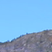

res
(-5.0, 5.0)


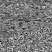

res
(-4.0, 3.0)


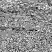

res
(-4.0, 4.0)


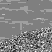

In [4]:
ds_it = iter(ds)
print(type(ds))

filenames = {ds.get_filename(i): i for i in range(len(ds))}
file_idx = filenames['0808_0']
# img1 = ds.get_max_bpp_img()
img1 = ds[file_idx]
print(img1.keys())
if 13 in img1:
    img1 = img1[13]
print(img1['bpp'])
show_tensor(img1['compressed'])
for c in range(3):
    print('res')
    show_tensor(img1['raw'][c, ...].float() - img1['compressed'][c, ...].float(), normalize=True, show_range=True)

In [5]:
from collections import defaultdict

from fjcommon.no_op import NoOp

import vis.safe_summary_writer
import vis.summarizable_module
from vis import image_summaries


class _FakeSummaryWriter(vis.safe_summary_writer.SafeSummaryWriter):
    def __init__(self):
        self.cache = None
        self.file_writer = NoOp
        self.clear()

    def add_scalar(self, tag, scalar_value, global_step=None):
        self.cache[global_step][tag] = scalar_value

    def add_image(self, tag, img_tensor, global_step=None, **kwargs):
        if len(img_tensor.shape) == 2:
            img = img_tensor.reshape(1, *img_tensor.shape)
        img = image_summaries.to_image(img_tensor)  # make sure this does not raise
        self.cache[global_step][tag] = img

    def add_text(self, tag, text_string, global_step=None):
        assert isinstance(text_string, str)
        self.cache[global_step][tag] = text_string

    def clear(self):
        self.cache = defaultdict(dict)

sw = _FakeSummaryWriter()
s = vis.summarizable_module.Summarizer(sw)
s.enable('val', 0)
t.blueprint.register_summarizer(s)

In [6]:
# t.blueprint.net.tail.sigmas.weight.shape
# show_tensor(t.blueprint.net.tail.sigmas.weight.squeeze(), normalize=True, blow_up=10, mi=0)
# show_tensor(t.blueprint.net.tail.means.weight.squeeze(), normalize=True, blow_up=10, mi=0)

In [7]:
# from helpers.notebook_dict import notebook_dict as nd

# t.blueprint.net.prob_clfs[0].atrous.lin.weight[:] = 1/192.

# print([n for n, _ in t.blueprint.net.named_parameters
from helpers.global_config import global_config
from blueprints.enhancement_blueprint import get_cin_classes
from modules import conditional_instance_norm

from torch.nn import functional as F
from helpers.quantized_tensor import NormalizedTensor

for img in (img1, ):
    x_n, bpps, _ = t.blueprint.unpack_batch_pad(img)# t.blueprint.get_padding_fac())
    out = t.blueprint.forward(x_n, bpps)
    

In [19]:
from torch import nn
from modules import prob_clf
taus = nn.Parameter(torch.ones(1, 3, 5, 1, 1, requires_grad=True))

# sigmas_orig = out.network_out.sigmas.clone()
network_out = out.network_out 

# out.network_out = out_new

optim = torch.optim.Adam([taus])
t.blueprint.losses.train(True)

# print(out.x_r.t.grad)
for i in range(1000):
    if taus.grad is not None:
        taus.grad.detach_()
        taus.grad.zero_()
        taus.grad = None
#     print(i, taus.reshape(-1).detach().cpu().numpy())
    
    new_sigmas = out.network_out.sigmas.detach() * taus
    out_new = prob_clf.NetworkOutput(network_out.means.detach(), new_sigmas, network_out.pis.detach(), network_out.lambdas.detach())
# 
    loss = t.blueprint.losses.loss_dmol_rgb(out.res, out_new).mean()
#     loss = 
#     nll = self.loss_dmol_rgb(out.res, out.network_out, scale=0)

    print('\r' + str(loss.item()), end='')#, taus.grad)
    loss.backward() 
#     print('backward done')
    optim.step()
    optim.zero_grad()


1.1858352422714233

In [ ]:
print(out)
from modules import prob_clf

sigmas_orig = out.network_out.sigmas.clone()
network_out = out.network_out 

def _new_out(sigmas):
    return prob_clf.NetworkOutput(network_out.means,
                                    sigmas,
                                    network_out.pis,
                                    network_out.lambdas)

for tau in (0.7, 0.8, 0.9, 1.0, 1.1):
    out_ = _new_out(sigmas_orig * tau)
    out.network_out = out_
    loss = t.blueprint.losses(out).total_loss
    print(loss)
    
print(sigmas_orig.shape)

In [ ]:
from lossy.other_codecs import bpg_compress_to, decode_bpg_to_png


# raw_p = ds.get_raw_p(img_idx)
# print(raw_p)

# t = torch.from_numpy(np.array())
import import_train_images
from helpers.quantized_tensor import SymbolTensor


def get_res(p1, p2):
    _i1 = torch.from_numpy(np.array(Image.open(p1))).long()
    _i2 = torch.from_numpy(np.array(Image.open(p2))).long()
    _res = _i1 - _i2
    return SymbolTensor(_res, L=511, centered=True).to_norm().t


# im_o = import_train_images.resize(Image.open(raw_p), res=768*0.75)
# im_o_p_jpg = 'some_tmp_debug_img.jpg'
# im_o_p_png = 'some_tmp_debug_img.png'
# im_o.save(im_o_p_jpg, quality=95)
# im_o.save(im_o_p_png)

# res_jpg_png = get_res(im_o_p_png, im_o_p_jpg)
# for c in range(3):
#     print(f'res_jpg_png{c}')
#     show_tensor(res_jpg_png[:200, :200, c], normalize=True, blow_up=2)
    

# im_o_p = im_o_p_jpg
# im_o_bpg_p = 'some_tmp_debug_img_bpg.png'

# bpg_compress_to(im_o_p, im_o_p + '_bpg', 10)
# decode_bpg_to_png(im_o_p + '_bpg', im_o_bpg_p)

# im_o_t = torch.from_n/umpy(np.array(Image.open(im_o_p))).long()
# im_o_bpg_t = torch.from_numpy(np.array(Image.open(im_o_bpg_p))).long()
# img_2 = im_o_t - im_o_bpg_t
# img_2 = SymbolTensor(img_2, L=511, centered=True).to_norm().t
# show_tensor()


# show_tensor(out.x_r.to_norm().t, normalize=True)
# print(out.res.t.shape)

sl = slice(None)
bu = 2

x_l = (out.x_r.t - out.res_sym.t).to(torch.uint8)
print(x_l.min(), x_l.max())

corrected_means = out.get_mean_img(t.blueprint.losses.loss_dmol_rgb)

loss = t.blueprint.losses.loss_dmol_rgb(out.res, out.network_out)
# show_tensor(out)

In [ ]:
res_mi, res_ma = out.res.t.min(), out.res.t.max()

for c in range(3):
    img_c = out.res.t[0, c, ...]
#     img_c_2 = img_2[..., c]
#     mi, ma = min(img_c.min(), img_c_2.min()), max(img_c.max(), img_c_2.max())
#     print(img_c.min(), img_c.max())
    print(f'x_r[{c}]')
    show_tensor(out.x_r.t[0, c, sl, sl].to(torch.uint8), blow_up=bu, show_range=True)
    print(f'x_l[{c}]')
    show_tensor(x_l[0, c, sl, sl], blow_up=bu)
#     print(f'JPG - BPG(JPG)[{c}]')
#     show_tensor(img_c_2[:200, :200], normalize=True, blow_up=2, mi=mi, ma=ma)
    print(f'out.res[{c}] (GT) == PNG - BPG(PNG)')
    show_tensor(img_c[sl, sl], normalize=True, blow_up=bu, show_range=True, mi=res_mi, ma=res_ma)#, mi=mi, ma=ma)
    
#     show_tensor(out.x_r.t[0,c,...].float() - x_l[0, c, ...].float(), normalize=True, blow_up=bu)
    
# for c in range(3):
    print(f'predicted_mean[{c}]')
    show_tensor(corrected_means[0, c, sl, sl], normalize=True, blow_up=bu, show_range=True, mi=res_mi, ma=res_ma)
    diff = out.res.t - corrected_means
    print(f'res - predicted_mean[{c}]')
    show_tensor(diff[0, c, sl, sl], normalize=True, blow_up=bu, show_range=True)
_, C, K, _, _ = out.network_out.sigmas.shape
    
    
logit_pis_sm = F.softmax(out.network_out.pis, dim=2)  # NCKHW, pi_k

scaled_sigmas = (out.network_out.sigmas * logit_pis_sm).sum(2)
# scaled_means  = (out.network_out.means  * logit_pis_sm).sum(2)


for c in range(C):
    print('---')
    print(f'SIGMA_scaled c{c};')
    show_tensor(scaled_sigmas[0, c, sl, sl], normalize=True, blow_up=bu, show_range=True)
    print(f'MEAN_corrected_scaled c{c}')
    show_tensor(corrected_means[0, c, sl, sl], normalize=True, blow_up=bu, show_range=True, mi=res_mi, ma=res_ma)

print('***\n***\n***\n***\n***')

# normalized_pis = 

for c in range(C):
    for k in range(K):
        print(f'PI c{c};k{k}')
        show_tensor(logit_pis_sm[0, c, k, sl, sl], normalize=True, blow_up=bu, show_range=True, mi=0, ma=1)
        print(f'SIGMA c{c};k{k}')
        show_tensor(out.network_out.sigmas[0, c, k, sl, sl], normalize=True, blow_up=bu, show_range=True)
        print(f'MEAN c{c};k{k}')
        show_tensor(out.network_out.means[0, c, k, sl, sl], normalize=True, blow_up=bu, show_range=True, mi=res_mi, ma=res_ma)
                         



# show_tensor(t.blueprint.net.heads[0].head[1].gamma, normalize=True)

# show_tensor(t.blueprint.net.prob_clfs[0].tail.means[0].gamma, normalize=True)
# print(t.blueprint.net.prob_clfs[0].tail.means[0].beta)
# loss_pc, nonrecursive_bpsps, _ = t.blueprint.get_loss(out)

# print(nonrecursive_bpsps)

# #     t.blueprint.add_image_summaries(sw, out, 0, 'val')

# print('loss', loss_pc)
# #     print(sw.cache[0].keys()) 
# lossy_rec = sw.cache[0]['val/predicted_mean']
# print(lossy_rec.shape)
# IPython.display.display(Image.fromarray((lossy_rec)))

# gt = s.get()[0, ...].permute(1, 2, 0).float()
# diff = torch.from_numpy(lossy_rec).float() - gt
# diff_arr = show_tensor(diff, normalize=True)

# Image.fromarray(diff_arr).save('test_db.png')
# print(os.path.getsize('test_db.png') * 8 / np.prod(diff_arr.shape))

# img_raw = sw.cache[0]['val/dmll/0/c2'][...]
# img = Image.fromarray(img_raw)
# IPython.display.display(img)

# #     w = t.blueprint.net.prob_clfs[0].atrous.lin.weight  # 12, 192
# #     w = w[2*3*1:3*3*1, ...]
# #     plt.figure()
# #     for k in range(w.shape[0]):
# #         plt.plot(range(w.shape[1]), w[k, :, 0, 0].detach().numpy())


# #     print('bitcost pp', nd['bitcost'][0, 2, 20:25, 20:25])

# #     bc = sw.cache[0]['val/dmll/bitcost/0'][...]

# #     IPython.display.display(Image.fromarray((bc > 0).astype(np.uint8) * 255))

# #     IPython.display.display(Image.fromarray(sw.cache[0]['val/dmll/bitcost/0'][...]))

# #     IPython.display.display(Image.fromarray(sw.cache[0]['val/bn/1'][...]))

In [ ]:
# print(os.listdir('tmp/new_age_feat_maps/'))
# # IPython.display.display(Image.open('tmp/new_age_feat_maps/after_body_0000000000.png'))
# IPython.display.display(Image.open('tmp/new_age_feat_maps/head_0000000000.png'))
# IPython.display.display(Image.open('tmp/new_age_feat_maps/body_bs_0000000000.png'))
# IPython.display.display(Image.open('tmp/new_age_feat_maps/body_as_0000000000.png'))
# IPython.display.display(Image.open('tmp/new_age_feat_maps/final_sigmas_0000000000.png'))
# IPython.display.display(Image.open('tmp/new_age_feat_maps/sigmas_0000000000.png'))
# IPython.display.display(Image.open('tmp/new_age_feat_maps/means_0000000000.png'))

In [ ]:
from bitcoding import coders_helpers



def get_C(l, x, chan=0):
    c = coders_helpers.CodingCDFNonshared(l, 3, t.blueprint.losses.loss_dmol_rgb)
    c.c_cur = chan
    C = c.get_next_C(x)
    return _get_C_cur_weighted(C.logit_probs_c_sm, c.targets, C.means_c, C.log_scales_c)

def _get_C_cur_weighted(logit_probs_softmax_c, targets, means_c, log_scales_c):
    C_cur = _get_C_cur(targets, means_c, log_scales_c)  # NKHWL
    C_cur = C_cur.mul(logit_probs_softmax_c.unsqueeze(-1)).sum(1)  # NHWL
    return C_cur


def _get_C_cur(targets, means_c, log_scales_c):  # NKHWL
    """
    :param targets: Lp floats
    :param means_c: NKHW
    :param log_scales_c: NKHW
    :return:
    """
    # NKHW1
#     print(log_scales_c.unique)
    inv_stdv = torch.exp(-log_scales_c).unsqueeze(-1)
#     print(inv_stdv.unique)
    # NKHWL'
    centered_targets = (targets - means_c.unsqueeze(-1))
#     print(centered_targets.shape, inv_stdv.shape)
    # NKHWL'
    arg = centered_targets.mul(inv_stdv)
#     print(arg.unique())
    cdf = arg.sigmoid()  # sigma' * (x - mu)
    return cdf



In [ ]:
%matplotlib notebook

from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt


print(torch.cuda.is_available())

import torch.nn.functional as F

print(out)
P = out.network_out
dmll = t.blueprint.losses.loss_dmol_rgb

img_raw = img1['raw'].float()

means = P.means
mean_ma,_ = torch.max(means,dim=2)
mean_mi,_ = torch.min(means,dim=2)
print(mean_ma.shape)
mean_diffs = mean_ma - mean_mi

In [ ]:
show_tensor(mean_diffs,normalize=True)
x_range = (153,163)
y_range = (183,184)
show_tensor(img_raw[..., slice(*x_range), slice(*y_range)],normalize=True, blow_up=10)
print(means.shape)

In [ ]:
# x_r, x_l = x_n
dmll.plot(out.res, P, plt, x_range=x_range, y_range=y_range)

In [ ]:
%matplotlib notebook

from ipywidgets import interact, interactive, fixed, interact_manual
import matplotlib.pyplot as plt


print(torch.cuda.is_available())

import torch.nn.functional as F

P = out.P[0]

x = t.blueprint.losses.loss_dmol_rgb.to_bn(p)



c1 = get_C(P, x, 0).detach().numpy()
c2 = get_C(P, x, 1).detach().numpy()
c3 = get_C(P, x, 2).detach().numpy()
print(c1.shape)

fig = None

f, axs = plt.subplots(3, 1, sharex=True)

for ci, ax in zip((c1, c2, c3), axs):
    for x in range(40, 50, 1):
        for y in range(40, 50, 1):
            data = ci[0, int(x), int(y), ...]
#                 print(data)
            ax.plot(np.arange(257), data)
plt.show()

# # def f(x=list(range(c1.shape[1])), y=list(range(c1.shape[2]))):
# def f(x, y):
#     plt.clf()
#     data = c1[0, int(x), int(y), ...]
# #    print(x, y, data)
#     plt.plot(np.arange(257), data)
# #     plt.ylim(0, 1)
#     plt.show()

# interactive_plot = interactive(f, x=(0, c1.shape[1]), y=(0, c1.shape[2]))
# output = interactive_plot.children[-1]
# output.layout.height = '550px'
# interactive_plot




In [ ]:
P = out.P[0][0, ...]
K = P.shape[0]//3//4
print(K)
H, W = P.shape[1], P.shape[2]

l = P.reshape(4, 3, K, H, W)

logit_probs = F.softmax(l[0, ...], dim=1)  # CKHW
means = l[1, ...]  # NCKHW
log_scales = torch.clamp(l[2, ...], min=-7)  # NCKHW, is >= -7
coeffs = l[3, ...]

for c in range(3):
    for k in range(K):
        logit_probs_c_k =  logit_probs[0, k, ...]
        if logit_probs_c_k.mean() < 0.01:
            continue
        print(k, means.min(), means.max(), logit_probs_c_k.mean())
        show_tensor(logit_probs_c_k.mul(255).round().to(torch.uint8), normalize=False)
        means_c_k = means[c, k, ...]
    #     means_c_k[logit_probs_c_k < 1e-3] = 0
        print('Means', c, means_c_k[10:20, 10:20])
        show_tensor(means_c_k, normalize=True)

        scales_c_k = log_scales[c, k, ...]
        print('Scales', c, scales_c_k[10:20, 10:20])

        coeffs_c_k = coeffs[c, k, ...]
        print('Coeffs', c, coeffs_c_k[10:20, 10:20])

        scales_c_k[logit_probs_c_k < 1e-3] = 0
        show_tensor(scales_c_k, normalize=True, mi=0)
    


In [ ]:
sigma = P[10:20, ...]
for k in range(10):
    show_tensor(sigma[k, ...], normalize=True)
